In [163]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip

In [106]:
import os

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [107]:
DATA_DIR = "/kaggle/working/captcha_images_v2"
BATCH_SIZE = 32
IMAGE_SHAPE = (50, 200, 1)
EPOCHS = 200

In [108]:
images = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR) if x.endswith(".png")]
labels = [x.split("/")[-1].replace(".png", "") for x in images if x.endswith(".png")]

In [109]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

In [110]:
max_length = max(len(x) for x in labels)

In [111]:
char_to_num = layers.StringLookup(
    vocabulary=characters, mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [112]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.cast(img, dtype=tf.float32) / 255.
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [113]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

In [114]:
dataset = dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)

In [115]:
train_size = int(0.8 * dataset.cardinality().numpy())

In [116]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [117]:
train_dataset = train_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

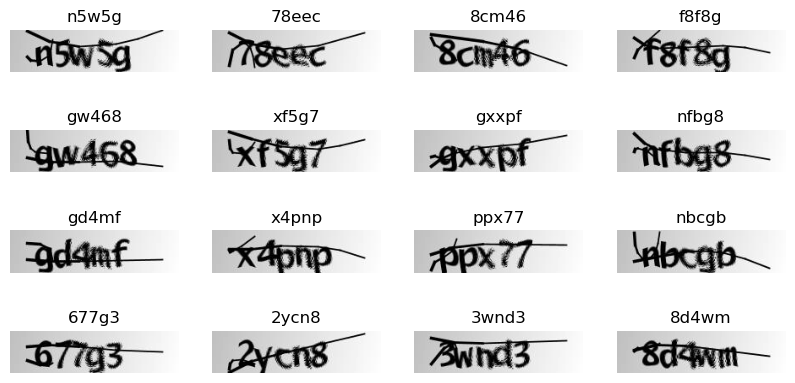

In [118]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [119]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int64)
        input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int64)
        label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int64)

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [120]:
def build_ocr_model():
    input_img = layers.Input(
        shape=(IMAGE_SHAPE[1], IMAGE_SHAPE[0], IMAGE_SHAPE[-1]), 
        name="image", dtype=tf.float32
    )
    labels = layers.Input(name="label", shape=(None,), dtype=tf.float32)
    
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(input_img)
    x = layers.AveragePooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D((2, 2))(x)
    
    new_shape = ((IMAGE_SHAPE[1] // 4), (IMAGE_SHAPE[0] // 4) * 64)
    x = layers.Reshape(new_shape)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, 
        activation="softmax", 
        name="out"
    )(x)
    
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    model = tf.keras.Model(
        inputs=[input_img, labels], outputs=output
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    
    return model

In [121]:
model = build_ocr_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 average_pooling2d_12 (AverageP  (None, 100, 25, 32)  0          ['conv2d_12[0][0]']              
 ooling2D)                                                                                        
                                                                                            

In [122]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        )
    ],
)

Epoch 1/200
26/26 [==============================] - 12s 129ms/step - loss: 82.0415 - val_loss: 85.1635
Epoch 2/200
26/26 [==============================] - 1s 51ms/step - loss: 20.1131 - val_loss: 32.8763
Epoch 3/200
26/26 [==============================] - 1s 47ms/step - loss: 16.9422 - val_loss: 33.0203
Epoch 4/200
26/26 [==============================] - 1s 46ms/step - loss: 16.6486 - val_loss: 35.6979
Epoch 5/200
26/26 [==============================] - 2s 64ms/step - loss: 16.5195 - val_loss: 34.0581
Epoch 6/200
26/26 [==============================] - 1s 45ms/step - loss: 16.4566 - val_loss: 31.7866
Epoch 7/200
26/26 [==============================] - 1s 46ms/step - loss: 16.4210 - val_loss: 29.1219
Epoch 8/200
26/26 [==============================] - 1s 45ms/step - loss: 16.3831 - val_loss: 26.4144
Epoch 9/200
26/26 [==============================] - 1s 47ms/step - loss: 16.3665 - val_loss: 23.8766
Epoch 10/200
26/26 [==============================] - 1s 50ms/step - loss: 16.34

In [123]:
prediction_model = tf.keras.Model(
    model.get_layer(name="image").input, model.get_layer(name="out").output
)

prediction_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 200, 50, 32)       320       
                                                                 
 average_pooling2d_12 (Avera  (None, 100, 25, 32)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 25, 64)       18496     
                                                                 
 batch_normalization (BatchN  (None, 100, 25, 64)      256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 100, 25, 64)       0   

In [124]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(
        pred, 
        input_length=input_len, greedy=True)[0][0][:, :max_length]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("UTF-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 0s 24ms/step


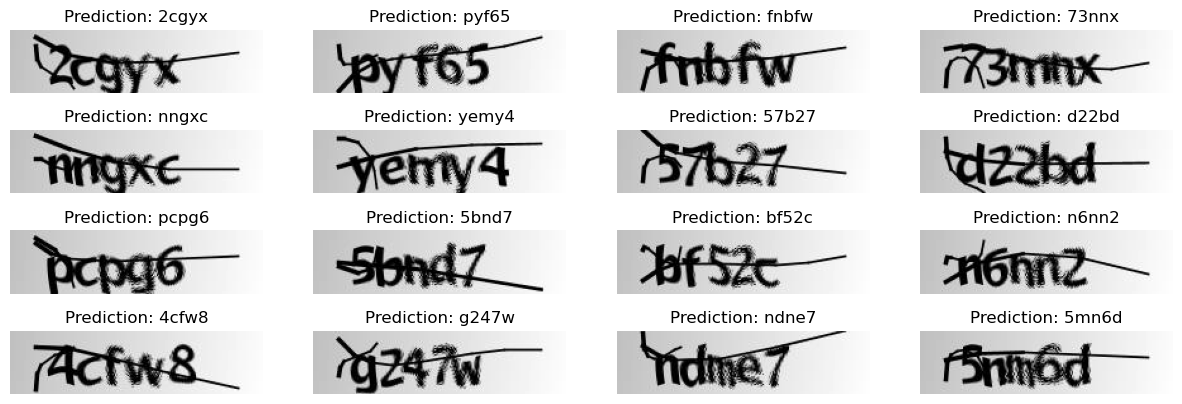

In [126]:
for batch in val_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("UTF-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts[:16])):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [127]:
def cer(y_true, y_pred):
    total_cer, total_chars = 0, 0

    for true, pred in zip(y_true, y_pred):
        true_len, pred_len = len(true), len(pred)
        dp = [[0] * (pred_len + 1) for _ in range(true_len + 1)]
        for i in range(true_len + 1):
            dp[i][0] = i
        for j in range(pred_len + 1):
            dp[0][j] = j
        for i in range(1, true_len + 1):
            for j in range(1, pred_len + 1):
                cost = 0 if true[i - 1] == pred[j - 1] else 1
                dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
        total_cer += dp[-1][-1]
        total_chars += len(true)

    return total_cer / total_chars

In [147]:
y_true = np.array(list(val_dataset.unbatch().map(lambda x: x["label"]).as_numpy_iterator()))
y_true = np.array([x for x in num_to_char(y_true).numpy()]).tolist()

In [148]:
gt_labels = []

for gt in y_true:
    temp = []
    for x in gt:
        temp.append(x.decode("UTF-8"))
    gt_labels.append(temp)

In [150]:
gt_labels = ["".join(x) for x in gt_labels]

In [153]:
y_pred = prediction_model.predict(val_dataset)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


7/7 [==============================] - 2s 11ms/step


In [154]:
y_pred = decode_batch_predictions(y_pred)

In [156]:
y_pred = [x.replace("[UNK]", "") for x in y_pred]

In [162]:
print(f"CER on validation dataset: {round(cer(gt_labels, y_pred) * 100, 2)}%")

CER on validation dataset: 4.62%
